# Using pre-trained network for bone age problem
The goal of this project is to identify the age of a child from an X-ray of their hand. This data was part of a competition http://rsnachallenges.cloudapp.net/competitions/4. We will build a model inspired by the one used by the winners of the competition. We will be using a pretrained network.

In [57]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

import pandas as pd
import numpy as np
import torch
from pathlib import Path
from torch.utils.data import Dataset, DataLoader
from torch.autograd import Variable
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
from torchvision import models
import random

In [10]:
import cv2
import matplotlib.pyplot as plt 

## Data

To get the data you can install the kaggle api using: <br/>
`pip install kaggle` <br/>
To get the dataset you can use this command line. (If you don't provide a path you will find your data in /home/user/.kaggle/datasets/kmader/rsna-bone-age/ )<br/>
`kaggle datasets download -d kmader/rsna-bone-age -p PATH` <br/>

In [11]:
PATH = Path("/data/yinterian/rsna-bone-age/")
list(PATH.iterdir())

[PosixPath('/data/yinterian/rsna-bone-age/boneage-training-dataset.csv'),
 PosixPath('/data/yinterian/rsna-bone-age/model.pth'),
 PosixPath('/data/yinterian/rsna-bone-age/boneage-training-dataset')]

In [13]:
! head /data/yinterian/rsna-bone-age/boneage-training-dataset.csv

id,boneage,male
1377,180,False
1378,12,False
1379,94,False
1380,120,True
1381,82,False
1382,138,True
1383,150,True
1384,156,True
1385,36,True


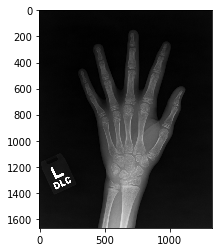

In [14]:
path = PATH/"boneage-training-dataset/9977.png"
im = cv2.imread(str(path))  #.astype(np.float32)/255
plt.imshow(im, cmap='gray')

In [15]:
im = cv2.imread(str(path))  #.astype(np.float32)/255
im.shape

(1668, 1323, 3)

In [16]:
# let's look at the typical size of these images
path = PATH/"boneage-training-dataset"
files = list(path.iterdir())[:200]
dims = [cv2.imread(str(p)).shape for p in files]
dims[:10]

[(1534, 1402, 3),
 (1997, 1516, 3),
 (1590, 1192, 3),
 (1706, 1706, 3),
 (1438, 1307, 3),
 (1432, 1174, 3),
 (1818, 1160, 3),
 (1473, 1064, 3),
 (1188, 1104, 3),
 (1815, 1163, 3)]

In [ ]:
ratios = [x[0]/x[1] for x in dims]

Here is a presentation with EDA on this data
https://alxndrkalinin.github.io/pdf/2017-12_CFT_BoneAge.pdf

## Data augmentation
The winners of the competition used real-time image augmentation consisting of horizontal/vertical translation, zoom, and rotation of 20 percent/degrees as well as horizontal flip. They used 500x500 images.

In [109]:
# modified from fast.ai
import math
def center_crop(im, min_sz=None):
    """ Returns a center crop of an image"""
    r,c,*_ = im.shape
    if min_sz is None: min_sz = min(r,c)
    start_r = math.ceil((r-min_sz)/2)
    start_c = math.ceil((c-min_sz)/2)
    return crop(im, start_r, start_c, min_sz, min_sz)

def crop(im, r, c, target_r, target_c): return im[r:r+target_r, c:c+target_c]

def random_crop(x, target_r, target_c):
    r,c,*_ = x.shape
    rand_r = random.uniform(0, 1)
    rand_c = random.uniform(0, 1)
    start_r = np.floor(rand_r*(r - target_r)).astype(int)
    start_c = np.floor(rand_c*(c - target_c)).astype(int)
    return crop(x, start_r, start_c, target_r, target_c)

def rotate_cv(im, deg, mode=cv2.BORDER_REFLECT, interpolation=cv2.INTER_AREA):
    """ Rotates an image by deg degrees"""
    r,c,*_ = im.shape
    M = cv2.getRotationMatrix2D((c/2,r/2),deg,1)
    return cv2.warpAffine(im,M,(c,r), borderMode=mode, flags=cv2.WARP_FILL_OUTLIERS+interpolation)

### Center crop

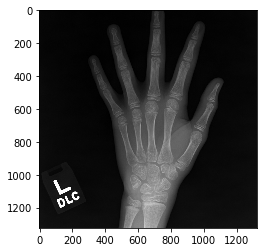

In [112]:
path = PATH/"boneage-training-dataset/9977.png"
im = cv2.imread(str(path))
im = center_crop(im)
plt.imshow(im, cmap='gray')

### Resize, horizontal and vertical translations

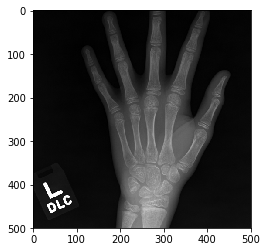

In [113]:
# resize desforms the image a bit
# note that by resizing to a larger number and random cropping we are doing horizontal and vertical translations
# we should try just center cropping the image instead of resizing
im = cv2.resize(im, (550, 550))
im = random_crop(im, 500, 500)
plt.imshow(im, cmap='gray')

### Random Rotation (-10, 10) 

-9.730746312809996


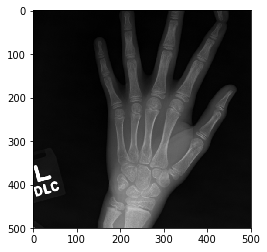

In [114]:
rdeg = (np.random.random()-.50)*20
print(rdeg)
im_rot = rotate_cv(im, rdeg)
plt.imshow(im_rot, cmap='gray')

### Horizontal Flip

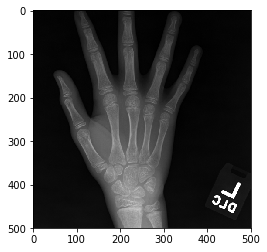

In [115]:
im_f = np.fliplr(im)
plt.imshow(im_f, cmap='gray')

## Split train and validation

In [21]:
df = pd.read_csv(PATH/"boneage-training-dataset.csv")
train = df.sample(frac=0.8, random_state=3).copy()
valid = df.drop(train.index).copy()

In [23]:
a = train.head()

In [35]:
row = a.iloc[0]
b = (1 if row["male"] == True else 0)
b

1

In [36]:
b = int(row["male"] == True)
b

1

## Dataset

In [136]:
class BoneAgeDataset(Dataset):
    def __init__(self, df, transforms=True):
        self.path_to_images = PATH/"boneage-training-dataset/"
        self.transforms = transforms
        self.df = df
        
    def __len__(self):
        return self.df.shape[0]
    
    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        path = str(self.path_to_images) + "/" + str(row["id"]) + ".png"
        y = row["boneage"]
        x2 = int(row["male"] == True)
        x = cv2.imread(str(path)).astype(np.float32)/255
        x = center_crop(x)
        if self.transforms:
            x = cv2.resize(x, (540, 540))
            x = random_crop(x, 500, 500)
            rdeg = (np.random.random()-.50)*20
            x = rotate_cv(x, rdeg)
            if np.random.random() > 0.8: x = np.fliplr(x).copy() 
        else:
            x = cv2.resize(x, (500, 500))
        return (np.rollaxis(x, 2), x2), y

In [137]:
train_ds = BoneAgeDataset(train)
valid_ds = BoneAgeDataset(valid, transforms=False)

In [138]:
batch_size = 16
train_dl = DataLoader(train_ds, batch_size=batch_size)
valid_dl = DataLoader(valid_ds, batch_size=batch_size)

In [139]:
# run this multiple times to get different images
x, y = train_ds[10]
x1, x2 = x
#plt.imshow(np.rollaxis(x1, 2), cmap='gray')

In [140]:
x1.shape,x2,y

((3, 500, 500), 1, 216)

## Model

In [180]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        resnet = models.resnet34(pretrained=True)
        for param in resnet.parameters():
            param.requires_grad = False
        layers = list(resnet.children())[:8]
        self.top_model = nn.Sequential(*layers)
        self.out = 512 + 32
        self.bn1 = nn.BatchNorm2d(self.out, eps=1e-05, momentum=0.1, affine=True)
        self.bn2 = nn.BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True)
        self.fc0 = nn.Linear(1, 32)
        self.fc1 = nn.Linear(self.out, 512)
        self.fc2 = nn.Linear(512, 1)
    
    def forward(self, x):
        img, x2 = x
        img = F.relu(self.top_model(img))
         #img1 = nn.AdaptiveMaxPool2d((1,1))(img)
        img2 = nn.AdaptiveAvgPool2d((1,1))(img)
        #img1 = img1.view(img1.shape[0], -1)
        img2 = img2.view(img2.shape[0], -1)
        x2 = self.fc0(x2.unsqueeze(1)).float()
        x = torch.cat([img2, x2], 1)
        x = nn.Dropout(0.2)(x)
        x = self.bn1(x)
        x = F.relu(self.fc1(x))
        x = nn.Dropout(0.2)(x)
        x = self.bn2(x)
        x = F.relu(self.fc2(x))
        return x

In [158]:
model = Net().cuda()

In [159]:
x,y = next(iter(train_dl))
x1, x2 = x

In [160]:
x1 = Variable(x1).cuda().float()
x2 = Variable(x2).cuda().float()
y = Variable(y).cuda().float()

In [161]:
x1.shape, x2.unsqueeze(1).shape

(torch.Size([16, 3, 500, 500]), torch.Size([16, 1]))

In [162]:
y_hat = model((x1, x2))

In [163]:
F.l1_loss(y_hat, y)

Variable containing:
 130.4562
[torch.cuda.FloatTensor of size 1 (GPU 0)]

## Train
We will optimize the mean absolute error (MAE). (reduced the learning rate by 20% after 10 epochs of plateau.)

In [151]:
def get_optimizer(model, lr = 0.01, wd = 0.0):
    parameters = filter(lambda p: p.requires_grad, model.parameters())
    optim = torch.optim.Adam(parameters, lr=lr, weight_decay=wd)
    return optim

In [183]:
def train_model(model, optim, train_dl=train_dl, verbose=False):
    model.train()
    total = 0
    sum_loss = 0
    for i, (x, y) in enumerate(train_dl):
        batch = y.shape[0]
        x1, x2 = x
        x1 = Variable(x1).cuda().float()
        x2 = Variable(x2).cuda().float()
        y = Variable(y).cuda().float()
        out = model((x1, x2))
        loss = F.l1_loss(out, y)
        
        optim.zero_grad()
        loss.backward()
        optim.step()
        total += batch
        sum_loss += batch*(loss.data[0])
        if verbose: print(sum_loss/total)
    return sum_loss/total

In [153]:
def val_loss(model, valid_dl):
    model.eval()
    total = 0
    sum_loss = 0
    for i, (x, y) in enumerate(valid_dl):
        batch = y.shape[0]
        x1, x2 = x
        x1 = Variable(x1).cuda().float()
        x2 = Variable(x2).cuda().float()
        y = Variable(y).cuda().float()
        out = model((x1, x2))
        loss = F.l1_loss(out, y)
        sum_loss += batch*(loss.data[0])
        total += batch
    print("val loss", sum_loss/total)
    return loss.data[0]

In [194]:
from datetime import datetime
def train_loop(model, epochs, lr=0.01, wd=0.0):
    optim = get_optimizer(model, lr = lr, wd = wd)
    for i in range(epochs):
        start = datetime.now()
        loss = train_model(model, optim, train_dl)
        end = datetime.now()
        t = 'Time elapsed (hh:mm:ss.ms) {}'.format(end - start)
        print("loss ", i, loss, t)
        val_loss(model, valid_dl)

In [202]:
model = Net().cuda()

In [196]:
#optim = get_optimizer(model, lr =.1, wd =0.0)
#loss = train_model(model, optim, train_dl, verbose=True)

In [ ]:
train_loop(model, epochs=10, lr=0.05, wd=0.0)

loss  0 25.42381304921356 Time elapsed (hh:mm:ss.ms) 0:06:52.184968
val loss 21.78213216764978
loss  1 22.93895130571495 Time elapsed (hh:mm:ss.ms) 0:06:48.731716
val loss 25.597907902039204
loss  2 22.949015871173316 Time elapsed (hh:mm:ss.ms) 0:06:50.755646
val loss 30.4551635155311


In [199]:
train_loop(model, epochs=5, lr=0.01, wd=0.0)

loss  0 22.688820816336474 Time elapsed (hh:mm:ss.ms) 0:07:31.593901
val loss 38.12631136041894
loss  1 22.361299535755315 Time elapsed (hh:mm:ss.ms) 0:07:30.885606
val loss 25.887596184823554
loss  2 21.570579890276587 Time elapsed (hh:mm:ss.ms) 0:07:29.306271
val loss 34.76482062827586
loss  3 22.21368067568695 Time elapsed (hh:mm:ss.ms) 0:07:31.287805
val loss 44.95899109987869
loss  4 21.931672756706643 Time elapsed (hh:mm:ss.ms) 0:07:14.145659
val loss 114.62090645622962


In [200]:
train_loop(model, epochs=10, lr=0.05, wd=0.0)

loss  0 20.63055352808309 Time elapsed (hh:mm:ss.ms) 0:06:52.502617
val loss 44.536520455017815
loss  1 20.858483895188293 Time elapsed (hh:mm:ss.ms) 0:06:53.006997
val loss 23.057963258590515
loss  2 20.358289297986566 Time elapsed (hh:mm:ss.ms) 0:06:50.582808
val loss 28.259199981931463
loss  3 20.152358686643947 Time elapsed (hh:mm:ss.ms) 0:06:54.801470
val loss 22.971267816663072
loss  4 20.214510212214925 Time elapsed (hh:mm:ss.ms) 0:06:52.656795
val loss 18.867837117835702
loss  5 20.257653116435478 Time elapsed (hh:mm:ss.ms) 0:06:48.848347
val loss 24.422670319002833
loss  6 19.952387873369517 Time elapsed (hh:mm:ss.ms) 0:06:47.606855
val loss 28.978002785690997
loss  7 19.899387100995597 Time elapsed (hh:mm:ss.ms) 0:06:50.093288
val loss 25.409397203897694
loss  8 20.231367348844792 Time elapsed (hh:mm:ss.ms) 0:06:51.715739
val loss 450.82946668741346
loss  9 19.914776464699163 Time elapsed (hh:mm:ss.ms) 0:06:49.957171
val loss 96.48424045704925


In [201]:
train_loop(model, epochs=10, lr=0.001, wd=0.0)

loss  0 19.422038737438942 Time elapsed (hh:mm:ss.ms) 0:06:51.503859
val loss 44.48694043231332
loss  1 19.290576821383073 Time elapsed (hh:mm:ss.ms) 0:06:50.401860
val loss 415.2714099415137
loss  2 18.94845641400181 Time elapsed (hh:mm:ss.ms) 0:06:49.660736
val loss 42.5225834993972
loss  3 18.98380877400002 Time elapsed (hh:mm:ss.ms) 0:06:48.348070
val loss 133.15389306161444
loss  4 18.990029486169284 Time elapsed (hh:mm:ss.ms) 0:06:48.807190
val loss 37.84855611469895
loss  5 18.88756720423521 Time elapsed (hh:mm:ss.ms) 0:06:51.187389
val loss 36.87360717567728
loss  6 19.06422029461777 Time elapsed (hh:mm:ss.ms) 0:06:50.782960
val loss 58.055282775794204
loss  7 18.862142909777177 Time elapsed (hh:mm:ss.ms) 0:06:48.151119
val loss 54.527085155272275
loss  8 18.911628512540272 Time elapsed (hh:mm:ss.ms) 0:06:47.198518
val loss 94.80104538829056
loss  9 18.983565504906117 Time elapsed (hh:mm:ss.ms) 0:06:49.089641
val loss 40.1905147392158


In [ ]:
def save_model(m, p): 
    torch.save(m.state_dict(), p)
p = PATH/"model.pth"
save_model(model, p)

In [97]:
p = PATH/"model.pth"
model.load_state_dict(torch.load(p))

In [145]:
val_loss(model, valid_dl)

val loss 19.491879188664655


20.56451988220215

In [149]:
p = PATH/"model005.pth"
save_model(model, p)

In [ ]:
# load model
p = PATH/"model005.pth"
model.load_state_dict(torch.load(p))

In [172]:
def set_trainable_attr(m, b=True):
    for p in m.parameters(): p.requires_grad = b

In [173]:
def unfreeze(model, l):
    top_model = model.top_model
    set_trainable_attr(top_model[l])

In [175]:
unfreeze(model, 7)

In [177]:
train_loop(model, epochs=5, lr=0.001, wd=0.0000)

Time elapsed (hh:mm:ss.ms) 0:07:46.733371
loss  0 13.772853367344476
Time elapsed (hh:mm:ss.ms) 0:07:54.559377
loss  1 13.18771737913793
val loss 17.323107559089145
Time elapsed (hh:mm:ss.ms) 0:07:55.942199
loss  2 13.481891490290854
Time elapsed (hh:mm:ss.ms) 0:07:54.645739
loss  3 13.227313383209987
val loss 12.371409078895999
Time elapsed (hh:mm:ss.ms) 0:07:29.913418
loss  4 12.72860453553946


In [178]:
train_loop(model, epochs=5, lr=0.0001, wd=0.0000)

Time elapsed (hh:mm:ss.ms) 0:07:54.343334
loss  0 12.432673157567086
Time elapsed (hh:mm:ss.ms) 0:07:55.405003
loss  1 12.29912730290805
val loss 15.374370425963194
Time elapsed (hh:mm:ss.ms) 0:07:53.842612
loss  2 12.189770003874695
Time elapsed (hh:mm:ss.ms) 0:07:54.364371
loss  3 12.134659048657621
val loss 12.232453401461184
Time elapsed (hh:mm:ss.ms) 0:07:17.849029
loss  4 12.082688829851335


# References

* https://www.16bit.ai/blog/ml-and-future-of-radiology
* https://stanfordmedicine.app.box.com/s/vhq1zop1867gr9rwnan4byj8lfxue173
* https://github.com/fastai/fastai/blob/master/courses/dl2/cifar10-darknet.ipynb